In [1]:
## ISOTOMICS CODE
## Written by tcsernica and szeichner
## Last update : march 18, 2024

#IMPORT DEPENDENCIES
import sys; sys.path.insert(0, 'lib')
import os
import copy
import json
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date

#IMPORT ISOTOMICS RELATED DATA
cwd = Path().resolve()
sys.path.insert(1, os.path.join(cwd, 'lib'))
import fragmentAndSimulate as fas
import calcIsotopologues as ci
import readInput as ri
import solveSystem as ss
import basicDeltaOperations as op
import fragmentAndSimulate as fas 
import organizeData
import dataAnalyzerMNIsoX as dA
import dataScreenIsoX as dataScreen
import readCSVAndSimulate as sim
import spectrumVis
import solveExperimentalData

In [14]:
today = date.today()

#SET GLOBAL PARAMETERS

#STEP #1: you need to set up a csv file for your molecule based on the stochiometry of the 
#fragment and molecular ion. See Csernica and Eiler, 2023 for explanation of how to set this up. 
#Also, see example files in the repository.
MOLECULE_INPUT_PATH = "Processed Data/Example Input.csv"

MOLECULAR_AVERAGE_TYPE = '13C/Unsub' #This is the type of ratio that is used to translate M+1 relative abundance space into site-specific values
                                            #This value can come from orbitrap or from EA

#Define details regarding your sample, which should come from external measurements.
MOLECULAR_AVERAGE_SAMPLE_COMPOSITION, MOLECULAR_AVG_SAMPLE_ERROR = -0.8, 0.1 #d13C value of VAN4 (from EA)
                                                                #Don't have EA data? You can get this value from orbitrap sample/standard comparisons that 
                                                                #you will be able to process using the experimental data functionality below. In that case, set both of these to None

#Define deatils regarding your standard, which could be from external measurements, or a guess.
STANDARD_DELTA_APPROX = [-11.9,-9.95,0,0,0,0] #these values should be in an array format that is the the same length 
                                                        # of your # of table rows (i.e., atomic sites constrained).
                                                        # this data could come from NMR, or be a guess. To model how that guess affects your 
                                                        # results, proceed to next code block.
#MOLECULAR_AVERAGE_STANDARD_COMPOSITION = computeMolecularAverage() #TODO: Add this
#print(MOLECULAR_AVERAGE_STANDARD_COMPOSITION)

In [3]:
#STEP 2: DECIDE IF YOU WANT TO MODEL A SYSTEM OR USE EXPERIMENTAL DATA.

#IF YOU WANT TO MODEL A SYSTEM, START HERE. IF NOT, PROCEED TO STEP X TODO CHANGE THIS STEP NUMBER:

#Define deltas for samples and standards to model a simple data set
SMP_DELTAS = [-11.9,-9.95,0,0,0,0]
STD_DELTAS = [-11.9,-9.95,0,0,0,0]

#Set a file name for your  model output results
OUTPUT_FILENAME = 'molecular_model_output.csv'

In [4]:
#SET ADDITIONAL (EXPERT) PARAMETERS FOR MODELED SYSTEM

ABUNDANCE_THRESHOLD = 0 #Simulation parameter: don't consider peaks below a certain abundance. If you're a novice user, leave this set to zero.
OMIT_MEASUREMENTS = {'M1':{'full':['17O']}} #Allows you to explictly define ion beams that you want to omit from analyses for any reason. (E.g., you do not observe them due to contamination, or lack of resolution, or low abundance.)
FRACTIONATION = True #Boolean to indicate whether or not your system is experiencing instrumental fractionation
FRACTIONATION_AMOUNT = 0.01 #Your guess of what that fractionation is (e.g., 0.05 = 50 per mille)


ERROR_PATH = 'Processed Data/Alanine Experimental Errors.csv' #CSV with values that specify your expectation for how good measurements should be for your modeled system.
                                                            #See example file for reference on how to set this up. Good starting places would be 13C error = 1 (per mille)
                                                            #2H error = 5 (per mille), etc.
MN_ERROR = 1 #This is the default error value in per-mille units that is set if you do not define errors in ERROR_PATH

In [5]:
#CONSTRUCT SYSTEM FROM CSV

#Intialize the molecule with your csv input
initializedMolecule = sim.moleculeFromCsv(os.path.join(cwd, MOLECULE_INPUT_PATH), deltas = STD_DELTAS)
#Simulate a measurement with the csv input molecule information
predictedMeasurement, MNDict, fractionationFactors = sim.simulateMeasurement(initializedMolecule, massThreshold = 5)

Folder 'Isotopologue tsv files' already exists.


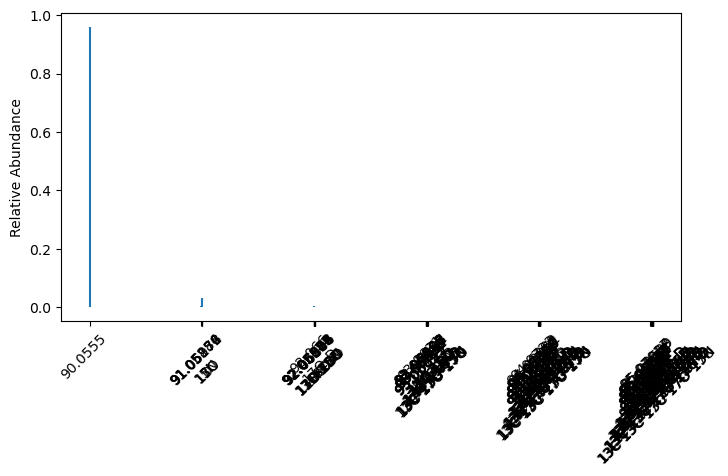

Folder 'Isotopologue tsv files' already exists.


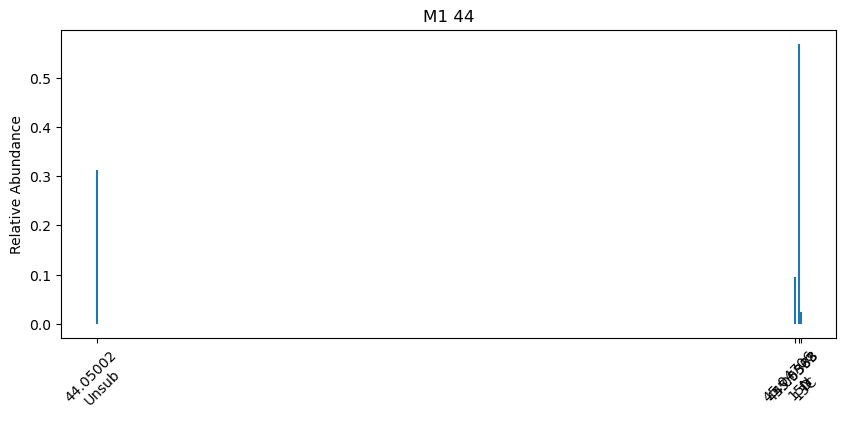

In [6]:
#EXPLORE SYSTEM
#We have extracted out some parameters and created two simplified plots that you can use to visualize the whole molecule,
#and an M+1 fragment example that you can look at as a mass spectrum. Feel free to play around to find what is more interesting to you!
FIG_SIZE = (8,4)

#Do you want to output an isotopologues.tsv file that can be used to process data in ISOX? If yes, set this variable below to "True"
OUTPUT_ISOTOPOLOGUES_FILE = True

#Visualize the full mass spectrum of your modeled molecule
spectrumVis.fullSpectrumVis(predictedMeasurement['Full Molecule'], initializedMolecule['molecularDataFrame'], figsize = FIG_SIZE, massError = 0, lowAbundanceCutOff = 0, xlim = (), ylim = (), outputIsotopologs=OUTPUT_ISOTOPOLOGUES_FILE)

#Visualize the mass spectrum for one M+1 fragment. You also need to run this code for every fragment in order to get an isotopologues.tsv file for each fragment.
#Set parameters
FRAGMENT_TO_EXPLORE = '44' #change this to be the string of your fragment mass, which was specified in your initial csv file
spectrumVis.MNSpectrumVis(initializedMolecule['molecularDataFrame'], FRAGMENT_TO_EXPLORE, predictedMeasurement, 'M1', MNDict, lowAbundanceCutOff = 0, massError = 0, xlim = (), ylim = (), outputIsotopologs=OUTPUT_ISOTOPOLOGUES_FILE)

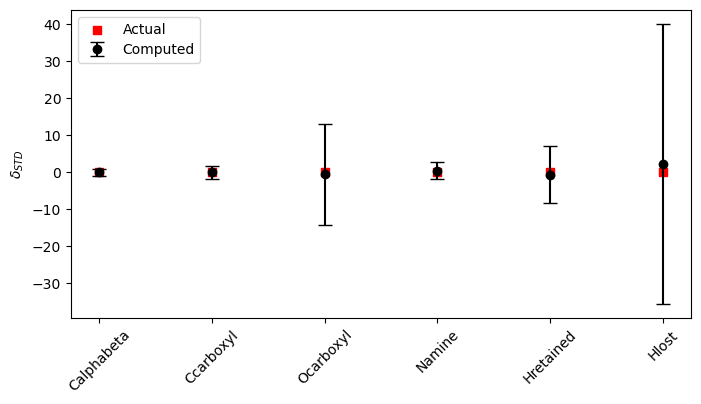

In [7]:
#GET SIMULATION OUTPUT
simulationOutput = sim.simulateSmpStd(os.path.join(cwd, MOLECULE_INPUT_PATH), STD_DELTAS, SMP_DELTAS, STANDARD_DELTA_APPROX, abundanceThreshold = 0, UValueList = [MOLECULAR_AVERAGE_TYPE.split('/')[0]], calcFF = FRACTIONATION, omitMeasurements = OMIT_MEASUREMENTS, ffstd = FRACTIONATION_AMOUNT, errorPath = ERROR_PATH, MNError = MN_ERROR, UValueError = MOLECULAR_AVG_SAMPLE_ERROR, resultsFileName = OUTPUT_FILENAME)

In [9]:
#STEP 3: SET UP TO PROCESS EXPERIMENTAL DATA

#SET PARAMETERS FOR THE MEASUREMENT
ACQUISITION_LENGTH = (5, 15) #Change the time here based on what subset of the acquisition you want to include it data processing. 
                                #You can change this based on TIC stability that you investigate in STEP 5 below.

#SET VARIABLES FOR DATA PROCESSING
PROCESSED_DATA_FOLDER_NAME = 'Processed Data' #name your folder that you want all processed data to go into (default: "Processed Data")
OUTPUT_FOLDER_NAME = 'Test_Data_Output' #name your folder within "Processed Data" that you want your experiment-specific
                                        #nested folders to be stored in (e.g., call it the name of your sample)
FILE_EXTENSION = '.isox' #set the extension to be whatever format your files are in. Currently, the code handles .isox files but could easily be
                         #adapted to read in other file formats by changing functions in the "dataAnalyzerMNIsoX.py" file
OUTPUT_TO_CSV = True #do you want to output your processed results to csv in 'PROCESSED_DATA_FOLDER_NAME'? If so, set to True.
CSV_OUTPUT_PATH = 'all_data_output.csv' #name what you want that output file to be.

#DETERMINE WHETHER TO RUN AUTOMATED DATA SCREENING
#If True, print a warning for peaks that have moved more than 'PEAK_DRIFT_THRESHOLD' in ppm from their expected position, benchmarked vs the observed position of the most abundant peak. See dataScreenIsoX for details. 
PEAK_DRIFT_SCREEN = True
PEAK_DRIFT_THRESHOLD = 2
#If True, print a warning for peaks that have a proportion of zero scans higher than the threshold. (I.e., more than 0.1% of scans are zero scans if threshold = 0.001)
ZERO_COUNTS_SCREEN = True
ZERO_COUNTS_THRESHOLD = 0
#If True, print a warning for peaks that have RSE/SN > 2. 
RSE_SN_SCREEN = True

In [10]:
#CREATE NESTED FOLDERS TO PUT YOUR DATA INTO FOR PROCESSING
fragmentDictionary = initializedMolecule['fragmentationDictionary']  #create a molecule based on your csv defined above in STEP #1.
new_folder_path = os.path.join(cwd, PROCESSED_DATA_FOLDER_NAME, OUTPUT_FOLDER_NAME) #set up the folder path
folderNames, parent_folder = organizeData.create_nested_folders(fragment_dict=fragmentDictionary.keys(), parent_folder=new_folder_path) #create the nested folders

#NOTE: Before moving to the next step, YOU NEED TO PUT YOUR EXPERIMENTAL DATA into the folders created in this step to be able to process

Folder already exists: C:\Users\tacse\Documents\Isotomics-Automated\Processed Data\Test_Data_Output\full
Folder already exists: C:\Users\tacse\Documents\Isotomics-Automated\Processed Data\Test_Data_Output\44


In [11]:
#STEP 4: PROCESS ALL DATA
fragmentFolderPaths = organizeData.get_subfolder_paths(parent_folder) #get names of folders for each relevant fragment

#process the data:
rtnMeans, rtnMergedDict = dA.processIndividualAndAverageIsotopeRatios(fragmentFolderPaths, cwd, outputToCSV=OUTPUT_TO_CSV, csvOutputPath = CSV_OUTPUT_PATH, file_extension = FILE_EXTENSION, processed_data_subfolder=PROCESSED_DATA_FOLDER_NAME, time_bounds = ACQUISITION_LENGTH, peakDriftScreen=PEAK_DRIFT_SCREEN, peakDriftThreshold=PEAK_DRIFT_THRESHOLD, zeroCountsScreen=ZERO_COUNTS_SCREEN, zeroCountsThreshold=ZERO_COUNTS_THRESHOLD, RSESNScreen=RSE_SN_SCREEN)

#Now, your individual acquisition data will be output to a csv at the path you defined above within the "Processed Data" folder, which you can use to 
#calculate molecular average isotope ratio measurements. in step 5, you can set individual path names to look at TIC variation over the length of an acquisition.

In [12]:
#STEP 5: SCREEN INDIVIDUAL DATA FILES
#This step allows you to copy full path names of each of your data files and visualize what the TIC of that acquistion looks like over time.

#SCAN_AVG_NUMBER = 50 #how many scans do you want to calculate tic averages over? 
#FILEPATH_TO_SCREEN = '/Users/sarahzeichner/Documents/GitHub/Isotomics-Automated/Processed Data/Test_Data_Output/full_molecular_average/Smp/02262024_vanC_153_1.isox'

#dataScreen.visualizeTICVersusTime(fileName=FILEPATH_TO_SCREEN, mergedDict=rtnMergedDict, targetRatio='13C/Unsub',scan_averaging_number = SCAN_AVG_NUMBER)

,IDS,Number,Fragment full,Fragment 44,Standard 1 Delta Values,Standard 2 Delta Values,VPDB etc. Deltas,VPDB etc. Deltas Error,Relative Deltas,Relative Deltas Error
Calphabeta,C,2,1,1,-30,-25,-10.976,0.766,0.935,0.775
Ccarboxyl,C,1,1,x,-30,-25,22.803,1.041,33.082,1.052
Ocarboxyl,O,2,1,x,0,10,0.494,15.640,0.494,15.640
Namine,N,1,1,1,0,10,0.374,1.254,0.374,1.254
Hretained,H,6,1,1,0,100,2.133,1.428,2.133,1.428
Hlost,H,2,1,x,0,-100,4.814,14.578,4.814,14.578


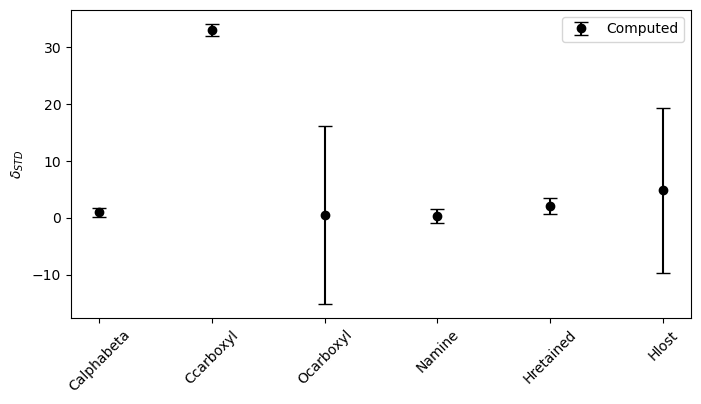

In [15]:
#STEP 6: SOLVE EXPERIMENTAL DATA FOR SITE SPECIFIC VALUES
solveExperimentalData.experimentalDataM1(rtnMeans, cwd, MOLECULE_INPUT_PATH, STANDARD_DELTA_APPROX, UValue = '13C/Unsub', mAObs = MOLECULAR_AVERAGE_SAMPLE_COMPOSITION, mARelErr=MOLECULAR_AVG_SAMPLE_ERROR, perturbTheoryOAmt=0.0003)